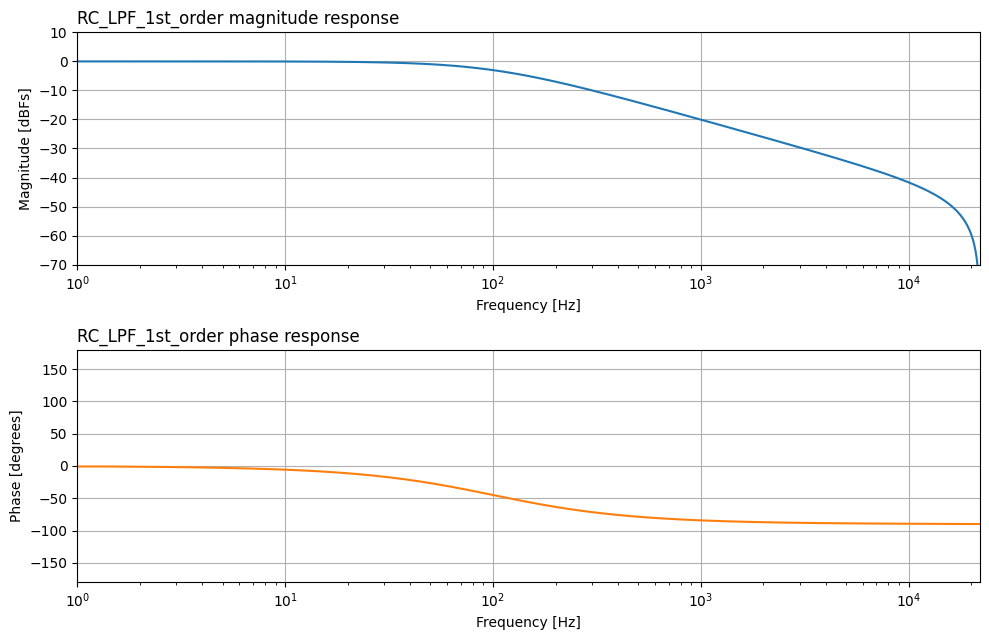

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from pywdf.core.wdf import *
from pywdf.core.circuit import Circuit
from sklearn.metrics import mean_squared_error

script_dir = Path().resolve()
ltspice_dir = script_dir.parent / "ltspice"

SAMPLERATE = 44100
cutoff = 100 # Hz

class RC_LPF_1st_order(Circuit):
    def __init__(self, sample_rate: int, cutoff: float) -> None:

        self.fs = sample_rate
        self.cutoff = cutoff

        self.C = 1e-6
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)

        self.R1 = Resistor(self.R)
        self.C1 = Capacitor(self.C, self.fs)

        self.S1 = SeriesAdaptor(self.R1, self.C1)
        self.I1 = PolarityInverter(self.S1)
        self.Vs = IdealVoltageSource(self.I1)

        super().__init__(self.Vs, self.Vs, self.C1)

    def set_cutoff(self, new_cutoff: float):
        if self.cutoff != new_cutoff:
            self.cutoff = new_cutoff
            self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)
            self.R1.set_resistance(self.R)


rc_lpf_1st = RC_LPF_1st_order(SAMPLERATE, cutoff)
rc_lpf_1st.plot_freqz()

In [3]:
# loading frequency response from LTspice

ltspice_ac_analysis_txt = ltspice_dir / "eval" / "frequency_analysis_dc_100hz_1st_order_lpf.txt"

In [ ]:
def load_ltspice_ac_analysis(file_path: Path) -> tuple:
    with open(file_path, 'r', encoding="latin") as f:
        # Read the contents of the file into a variable
        data = [line.strip().split() for line in f]
        # Print the names

    header = data[0]
    data = data[1:]

    # let's define some bins to store the data
    frequencies, magnitudes, phases = (list() for _ in range(3))

    for row in data:    # row[0] contains the frequency stamps and row[1] magnitude and phase
        magnitude_and_phase = row[1]
        frequencies.append(float(row[0]))
        magnitude_and_phase = list(map(float, row[1][1:-2].split("dB,")))
        magnitudes.append(magnitude_and_phase[0])
        phases.append(magnitude_and_phase[1])

    frequencies = np.array(frequencies)
    magnitudes = np.array(magnitudes)
    phases = np.array(phases)

    return header, frequencies, magnitudes, phases

header: ['Freq.', 'V(n002)']
fft_length: 14430


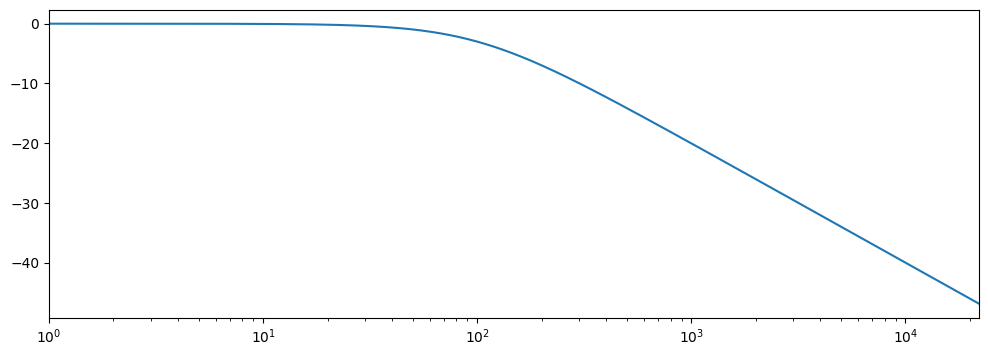

In [ ]:
header, lts_frequencies, lts_magnitudes, lts_phases = load_ltspice_ac_analysis(ltspice_ac_analysis_txt)
print(f"header: {header}")
print(f"fft_length: {len(lts_frequencies)}")
_, ax = plt.subplots(figsize=(12,4))
plt.semilogx(lts_frequencies, lts_magnitudes)
hearing_frequency_range = 22050
plt.xlim([10**0, hearing_frequency_range / 10000 * 10**4])
plt.show()

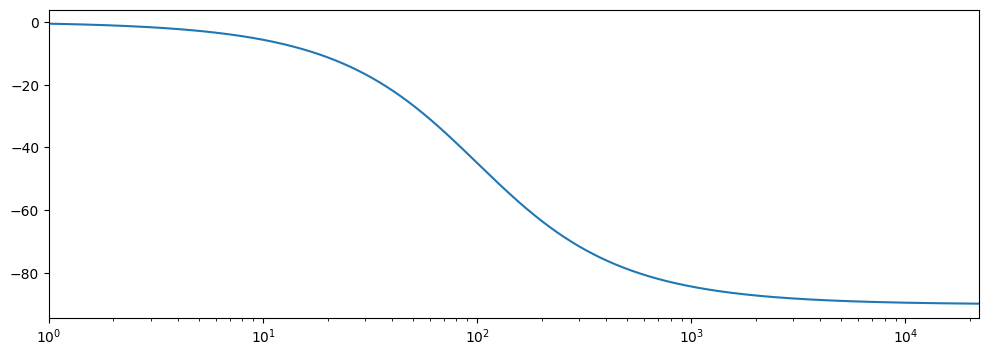

In [6]:
_, ax = plt.subplots(figsize=(12,4))
plt.semilogx(lts_frequencies, lts_phases)
plt.xlim([10**0, hearing_frequency_range / 10000 * 10**4])
plt.show()

In [7]:
# let's get the same responses form pywdf virtualization

from scipy.fftpack import fft


# we need to define the test signal (dirac delta or impulse response)
def get_impulse_response(processor: object, sample_rate: int, delta_dur: float = 1, amp: float = 1) -> np.array:
    """Get circuit's impulse response

    Args:
        delta_dur (float, optional): duration of Dirac delta function in seconds. Defaults to 1.
        amp (float, optional): amplitude of delta signal's first sample. Defaults to 1.

    Returns:
        np.array: impulse response of the system
    """
    d = np.zeros(int(delta_dur * sample_rate))
    d[0] = amp
    return processor(d)

# We'll need to compute the spectrum
def compute_spectrum(processor: object, sample_rate: int, fft_size: int = None) -> np.ndarray:
    x = get_impulse_response(processor, sample_rate=sample_rate)
    N2 = int(fft_size / 2 - 1)
    H = fft(x, fft_size)[:N2]
    return H

SAMPLE_RATE = 44100
ltspice_fft_size = 28862
H = compute_spectrum(rc_lpf_1st, SAMPLE_RATE, ltspice_fft_size)

# We'll need to estimate magnitude
magnitudes = 20 * np.log10(np.abs(H) + np.finfo(np.float16).eps)

# We'll need to estimate phase
phases = np.angle(H)

# We'll need some frequency stamps
frequencies = np.linspace(0, SAMPLE_RATE/2, int(ltspice_fft_size / 2 - 1))


14430


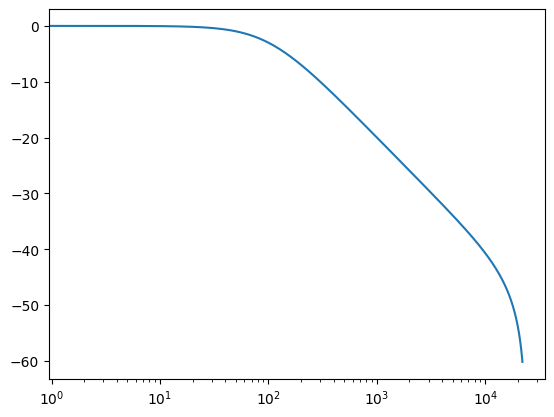

In [8]:
print(len(frequencies))
plt.semilogx(frequencies, magnitudes)
plt.show()

In [9]:
mse = mean_squared_error(lts_magnitudes, magnitudes)
print(f"mse: {mse}")

mse: 840.7514848057705


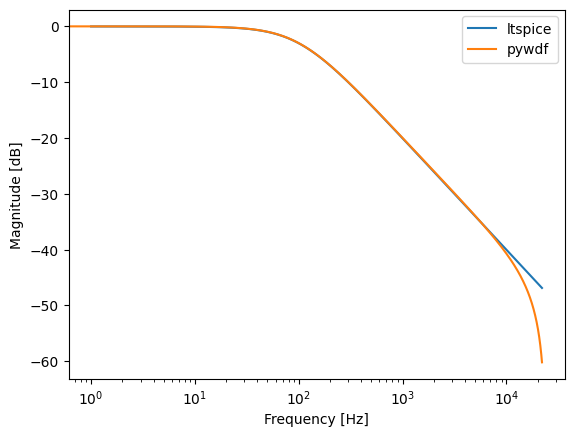

In [10]:
plt.semilogx(lts_frequencies, lts_magnitudes, label="ltspice")
plt.semilogx(frequencies, magnitudes, label = "pywdf")
plt.ylabel("Magnitude [dB]")
plt.xlabel("Frequency [Hz]")
plt.legend()
plt.show()

As we can observe in the upper figure, there is a limited frequency range to compare fairly the magnitude response `[1, 10000][Hz]` further than this the model starts to be unstable.